# Model for the Judge Panels in the US Appellate Court

In this notebook we implement a model for the voting pattern in the U.S. Appellate Court as analyzed by _C. Sunstein_ in the book [Are Judges Political?](https://www.amazon.com/Are-Judges-Political-Empirical-Judiciary/dp/0815782349), where he test four hypothesis, (which are?), about the judges behavior and arugment how the court dicisions support them.

The model was designed to use the Entropic Dynamics for learning agents and the code is based on the implementation for the opinion-distrust agent models.
First we present Sunstein's data and perform some analysis of our own, then we implement the class to control for the initial conditions and interaction details, them we proceed to investigate if and how the his hypothesis show up in the model.

## Data and some analysis

The data  represent the percentages individual and panel liberal votes in fourteen case types here and can be
found at pages 27 and 28 from the book 
[Are Judges Political?](https://www.amazon.com/Are-Judges-Political-Empirical-Judiciary/dp/0815782349), from
where we did a straight copy and paste to this notebook.

In [258]:
import pandas as pd
from collections import OrderedDict, namedtuple

book_data = OrderedDict({
'Affirmative action':     OrderedDict({('rr','R'):.34,('rr','D'):.60,
                                       ('rd','R'):.46,('rd','D'):.83,
                                       ('dd','R'):.69,('dd','D'):.81}),
'NEPA':                   OrderedDict({('rr','R'):.20,('rr','D'):.10,
                                       ('rd','R'):.06,('rd','D'):.42,
                                       ('dd','R'):.42,('dd','D'):.71}),
'11th Amendment':         OrderedDict({('rr','R'):.26,('rr','D'):.58,
                                       ('rd','R'):.46,('rd','D'):.54,
                                       ('dd','R'):.44,('dd','D'):.73}),
'NLRB':                   OrderedDict({('rr','R'):.23,('rr','D'):.50,
                                       ('rd','R'):.42,('rd','D'):.57,
                                       ('dd','R'):.55,('dd','D'):.75}),
'Sex discrimination':     OrderedDict({('rr','R'):.30,('rr','D'):.42,
                                       ('rd','R'):.37,('rd','D'):.52,
                                       ('dd','R'):.44,('dd','D'):.76}),
'ADA':                    OrderedDict({('rr','R'):.17,('rr','D'):.35,
                                       ('rd','R'):.29,('rd','D'):.45,
                                       ('dd','R'):.38,('dd','D'):.50}),
'Campaign finance':       OrderedDict({('rr','R'):.31,('rr','D'):.35,
                                       ('rd','R'):.26,('rd','D'):.39,
                                       ('dd','R'):.37,('dd','D'):.62}),
'Piercing corporate veil':OrderedDict({('rr','R'):.21,('rr','D'):.30,
                                       ('rd','R'):.26,('rd','D'):.36,
                                       ('dd','R'):.34,('dd','D'):.60}),
'EPA':                    OrderedDict({('rr','R'):.40,('rr','D'):.55,
                                       ('rd','R'):.54,('rd','D'):.58,
                                       ('dd','R'):.58,('dd','D'):.76}),
'Obscenity':              OrderedDict({('rr','R'):.20,('rr','D'):.35,
                                       ('rd','R'):.29,('rd','D'):.34,
                                       ('dd','R'):.33,('dd','D'):.44}),
'Title VII':              OrderedDict({('rr','R'):.39,('rr','D'):.34,
                                       ('rd','R'):.30,('rd','D'):.47,
                                       ('dd','R'):.34,('dd','D'):.54}),
'Desegregation':          OrderedDict({('rr','R'):.56,('rr','D'):.71,
                                       ('rd','R'):.67,('rd','D'):.77,
                                       ('dd','R'):.72,('dd','D'):.71}),
'FCC':                    OrderedDict({('rr','R'):.54,('rr','D'):.47,
                                       ('rd','R'):.41,('rd','D'):.61,
                                       ('dd','R'):.66,('dd','D'):.80}),
'Contract clause':        OrderedDict({('rr','R'):.17,('rr','D'):.26,
                                       ('rd','R'):.27,('rd','D'):.31,
                                       ('dd','R'):.38,('dd','D'):.50}),
'Commercial speech':       OrderedDict({('rr','R'):.49,('rr','D'):.57,
                                       ('rd','R'):.50,('rd','D'):.64,
                                       ('dd','R'):.69,('dd','D'):.53})
})

judges_data = pd.DataFrame(book_data).T

judges_data.index.name = 'Case type'
judges_data.columns.names = ['Panel composition', 'Apointee party']
judges_data

Panel composition          dd          rd          rr      
Apointee party              D     R     D     R     D     R
Case type                                                  
Affirmative action       0.81  0.69  0.83  0.46  0.60  0.34
NEPA                     0.71  0.42  0.42  0.06  0.10  0.20
11th Amendment           0.73  0.44  0.54  0.46  0.58  0.26
NLRB                     0.75  0.55  0.57  0.42  0.50  0.23
Sex discrimination       0.76  0.44  0.52  0.37  0.42  0.30
ADA                      0.50  0.38  0.45  0.29  0.35  0.17
Campaign finance         0.62  0.37  0.39  0.26  0.35  0.31
Piercing corporate veil  0.60  0.34  0.36  0.26  0.30  0.21
EPA                      0.76  0.58  0.58  0.54  0.55  0.40
Obscenity                0.44  0.33  0.34  0.29  0.35  0.20
Title VII                0.54  0.34  0.47  0.30  0.34  0.39
Desegregation            0.71  0.72  0.77  0.67  0.71  0.56
FCC                      0.80  0.66  0.61  0.41  0.47  0.54
Contract clause          0.50  0.38  0.31  0.27  0.26  0.17
Commercial speech        0.53  0.69  0.64  0.50  0.57  0.49

The number of cases, from presidents Eisenhower to Bush, can be found in the pages 118 and 119, although the data from the previous table uses mostly data from the period of 1995 to 2004.

In [259]:
cases_data = pd.DataFrame({'Affirmative action': {'Number of cases': 481.},
                           'Abortion': {'Number of cases': 435},
                           'ADA': {'Number of cases': 2253},
                           'Campaign finance': {'Number of cases': 195},
                           'Capital punishment': {'Number of cases': 624},
                           'Contract clause': {'Number of cases': 233},
                           'Criminal appeals': {'Number of cases': 2795},
                           'EPA': {'Number of cases': 543},
                           'Federalism': {'Number of cases': 960},
                           'Piercing corporate veil': {'Number of cases': 345},
                           'Sex discrimination': {'Number of cases': 2144},
                           'Takings': {'Number of cases': 654},
                           'Title VII': {'Number of cases': 1089},
                           'Punitive damages': {'Number of cases': 264},
                           'First Amendment': {'Number of cases': 290},
                           'Obscenity': {'Number of cases': 484},
                           'Gay and lesbian rights': {'Number of cases': 65},
                           'NEPA': {'Number of cases': 273},
                           'Desegregation': {'Number of cases': 739},
                           'Standing': {'Number of cases': 762},
                           'FCC': {'Number of cases': 327},
                           '11th Amendment': {'Number of cases': 318},
                           'NLRB': {'Number of cases': 216}}).T

cases_data = cases_data.loc[judges_data.index].drop('Commercial speech').assign(Fraction=cases_data['Number of cases']/cases_data['Number of cases'].sum())
cases_data

,Number of cases,Fraction
Case type,,
Affirmative action,481.0,0.029171
NEPA,273.0,0.016556
11th Amendment,318.0,0.019286
NLRB,216.0,0.013100
Sex discrimination,2144.0,0.130026
ADA,2253.0,0.136637
Campaign finance,195.0,0.011826
Piercing corporate veil,345.0,0.020923
EPA,543.0,0.032931


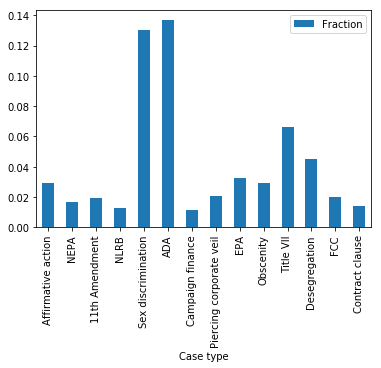

In [260]:
cases_data.plot(y='Fraction', kind='bar')

To reproduce each of the bar plots in _Sunstein's_ book, we use the function:

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

def sunstein_bars(book_df, case_type, ax=None):
    if ax is None:
        ax = plt.gca()
    df = book_df.loc[case_type].unstack(level=1).iloc[-1::-1][['R','D']]
    df.plot(ax=ax, kind='bar', 
            rot=0, fontsize=12, 
            yticks=[0.2,0.4,0.6,0.8], ylim=(0,1),
            color=['#cccccc', '#ffffff'], lw=1, edgecolor='k')
    ax.set_title(case_type)
    ax.set_ylabel('Percent liberal votes')
    for p in ax.patches:
        ax.annotate(str(p.get_height()).split('.')[1].ljust(2,'0'),
                    (p.get_x() + 0.055, p.get_height() + 0.025))
    ax.legend(['Republican appointees', 'Democratic appointees'], 
               mode='expand', frameon=False, ncol=2, loc=(0,-0.2))
    return ax

/usr/lib/python3.6/site-packages/matplotlib/style/core.py:197: UserWarning: In /home/felippe/.config/matplotlib/stylelib/tableau10.mplstyle: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(message)


And all the bar plots are

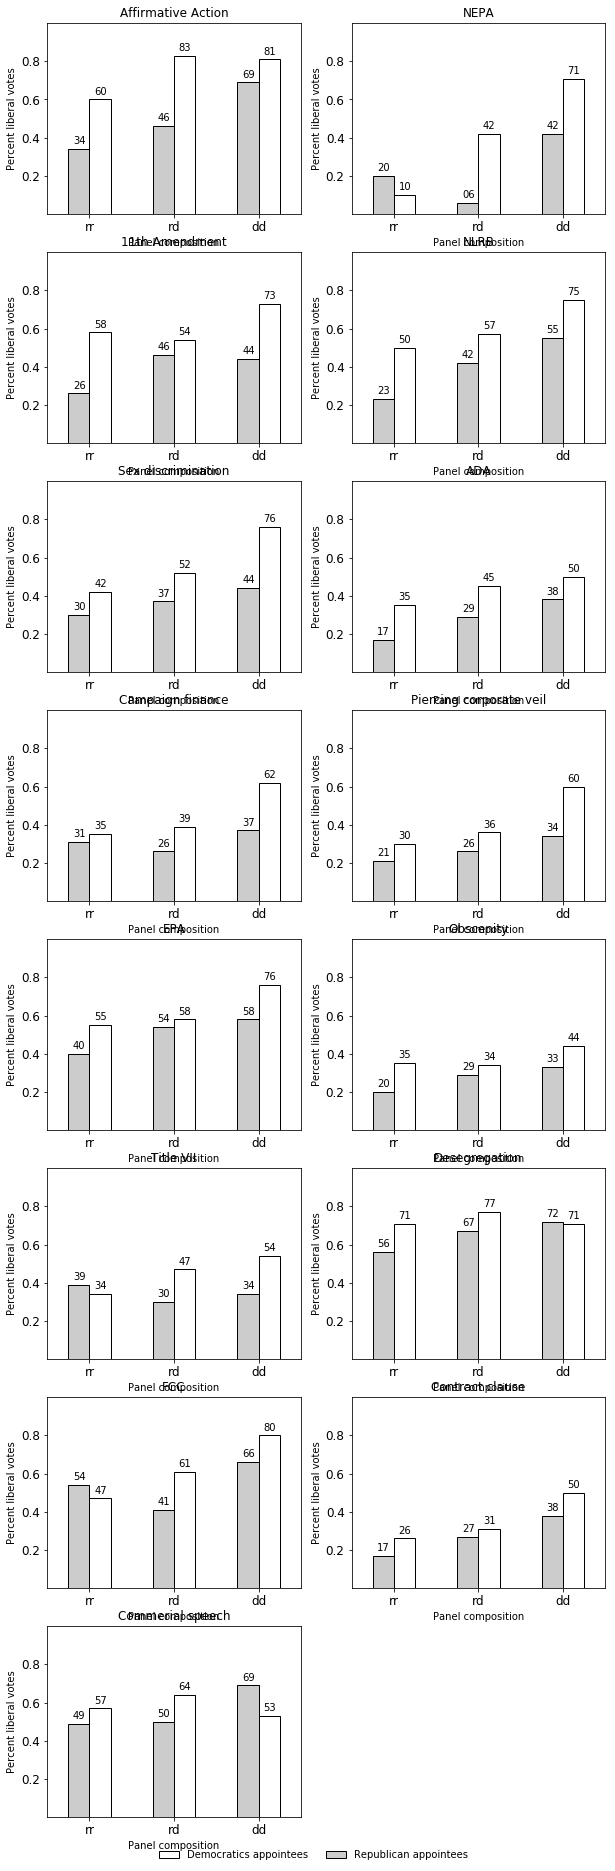

In [3]:
fig, axs = plt.subplots(figsize=(10,33), ncols=2, nrows=8)
axs[-1,1].set_visible(False)
for ax, ct in zip(axs.ravel()[:-1], judges_data.index):
    _ = sunstein_bars(judges_data, ct, ax=ax)
    ax.get_legend().set_visible(False)
h,l = axs[0,0].get_legend_handles_labels()
fig.legend(h, ['Republican appointees', 'Democratics appointees'],
           loc='upper center', mode='expand', frameon=False, ncol=2,
           bbox_to_anchor=(.5,.115), bbox_transform=fig.transFigure)

We want to measure the similarity between different panel compositions across the case types, so we make a
transformation to the percentual values to convert them to real vectors in a 15-vector representation to use
the internal product as such measure.

To transform the values, we consider a linear tranformation $y = 2x-1$ and the inverse $\Phi$ $y = \Phi^{-1}(x) = \sqrt{2}\mathrm{erf}^{-1}(2x-1)$, followed by a normalization of the resulting vectors

In [4]:
from scipy.special import erfinv, erf, erfc
from numpy import sqrt
from numpy.linalg import norm

Phi    = lambda x: erfc(-x/sqrt(2))/2
invPhi = lambda x: sqrt(2)*erfinv(2*x-1)
linear = lambda x: 2*x - 1 

def plot_matrix(df, order=None, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    if order is None:
        order = df.columns.tolist()
    im = ax.imshow(df[order].T[order].T, **kwargs)
    ax.set_xticks(arange(0,6))
    ax.set_yticks(arange(0,6))
    ax.set_xticklabels(order + [' '])
    ax.set_yticklabels(order + [' '])
    return ax, im

In [5]:
trans_data = judges_data.transform(lambda x, f=linear: f(x)/norm(f(x)))
linear_overlaps = trans_data.T.dot(trans_data)
linear_overlaps.index = [''.join(reversed(idx)) for idx in linear_overlaps.index]
linear_overlaps.columns = [''.join(reversed(c)) for c in linear_overlaps.columns]
linear_overlaps

,Ddd,Rdd,Drd,Rrd,Drr,Rrr
Ddd,1.000000,0.292014,0.498231,-0.354647,-0.083477,-0.509865
Rdd,0.292014,1.000000,0.886943,0.618621,0.731595,0.503100
Drd,0.498231,0.886943,1.000000,0.479484,0.694059,0.286860
Rrd,-0.354647,0.618621,0.479484,1.000000,0.933392,0.847378
Drr,-0.083477,0.731595,0.694059,0.933392,1.000000,0.683850
Rrr,-0.509865,0.503100,0.286860,0.847378,0.683850,1.000000


In [6]:
trans_data = judges_data.transform(lambda x, f=invPhi: f(x)/norm(f(x)))
invPhi_overlaps = trans_data.T.dot(trans_data)
invPhi_overlaps = trans_data.T.dot(trans_data)
invPhi_overlaps.index = [''.join(reversed(idx)) for idx in invPhi_overlaps.index]
invPhi_overlaps.columns = [''.join(reversed(c)) for c in invPhi_overlaps.columns]
invPhi_overlaps

,Ddd,Rdd,Drd,Rrd,Drr,Rrr
Ddd,1.000000,0.307920,0.516455,-0.352026,-0.104686,-0.486709
Rdd,0.307920,1.000000,0.876311,0.570710,0.684351,0.500162
Drd,0.516455,0.876311,1.000000,0.429794,0.635120,0.274509
Rrd,-0.352026,0.570710,0.429794,1.000000,0.947280,0.813282
Drr,-0.104686,0.684351,0.635120,0.947280,1.000000,0.681111
Rrr,-0.486709,0.500162,0.274509,0.813282,0.681111,1.000000


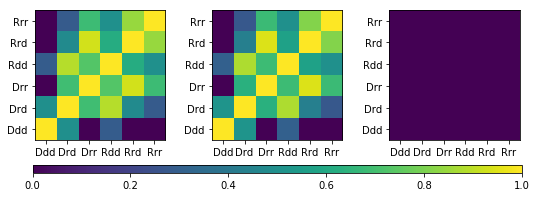

In [7]:
from numpy import arange

fig, axs = plt.subplots(figsize=(9,3), ncols=3)
order = 'Ddd Drd Drr Rdd Rrd Rrr'.split()
_, im = plot_matrix(linear_overlaps, order, ax=axs[0], vmin=0, vmax=1, origin='lower')
plot_matrix(invPhi_overlaps, order, ax=axs[1], vmin=0, vmax=1, origin='lower')
plot_matrix(((linear_overlaps - invPhi_overlaps)**2), order, ax=axs[2], vmin=0, vmax=1, origin='lower')
fig.colorbar(im, ax=axs.tolist(), fraction=0.05, orientation='horizontal', aspect=60)

But since they are almost the same, we keep the linar overlaps for the analysis, as they are simpler.
Lets compare the angles between different panel compositions

In [8]:
from numpy import arccos, pi

def plot_angle(angle_df, x_order, y_order, ax=None, *args, **kwargs):
    if ax is None:
        ax = plt.gca()
    angle_df[y_order].T[x_order].T.plot(ax=ax, **kwargs)
    ax.legend(loc='upper right', frameon=True)
    ax.set_ylim(0, pi)
    ax.set_yticks([0, pi/4, pi/2, 3*pi/4, pi])
    ax.set_yticklabels(['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'],
                       fontdict={'size':14})
    ax.set_ylabel(r'$\theta$', fontdict={'size':16})
    return ax

angle_data = linear_overlaps.transform(lambda x: arccos(0.999*x))

def plot_angle_pairs(angle_df, x_order, *pairs, title='', **kwargs):
    n = len(pairs)
    fig, axs = fig, axs = plt.subplots(figsize=(4*n,n), ncols=n)
    for ax,p in zip(axs.tolist(), pairs):
        plot_angle(angle_df, x_order, p, ax=ax, **kwargs)
    fig.suptitle(title, fontsize=16)
    fig.tight_layout(pad=2.5, h_pad=0.1, w_pad=0.1)
    return fig, axs

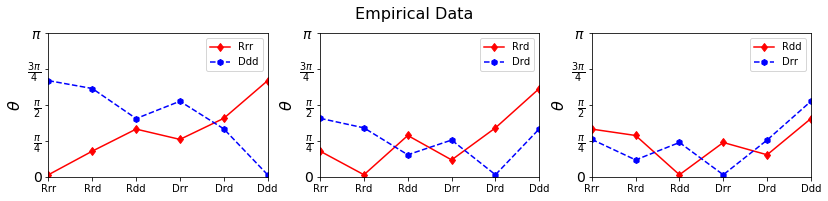

In [9]:
x_order = 'Rrr Rrd Rdd Drr Drd Ddd'.split()
_ = plot_angle_pairs(angle_data, x_order, ['Rrr', 'Ddd'], ['Rrd', 'Drd'], ['Rdd', 'Drr'],
                     title='Empirical Data', color=['r', 'b'], style=['-d', '--h'])

and the angle flag is

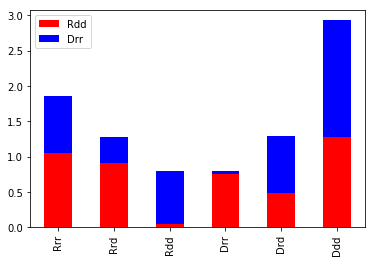

In [165]:
angle_data.T[x_order].T[['Rdd','Drr']].plot(kind='bar', stacked=True, color=['r', 'b'])

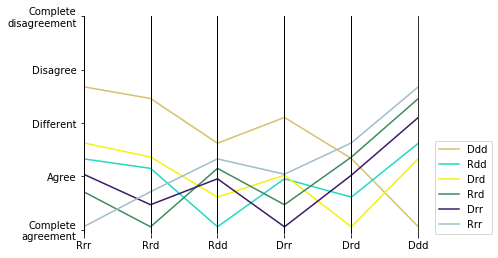

In [154]:
from pandas.plotting import parallel_coordinates

foo = parallel_coordinates(angle_data[x_order].reset_index(), 'index', axvlines_kwds={'ls':'-', 'c':'k', 'lw':1})
foo.grid(False)
for s in ['top', 'bottom']:
    foo.spines[s].set_visible(False)
foo_lgd = foo.get_legend_handles_labels()
foo.legend(*foo_lgd, loc=(1.05,0))
foo.set_yticks([0,pi/4,pi/2,3*pi/4,pi])
_ = foo.set_yticklabels(['Complete\nagreement', 'Agree', 'Different', 'Disagree', 'Complete\ndisagreement'],
                         fontdict={'size':10})

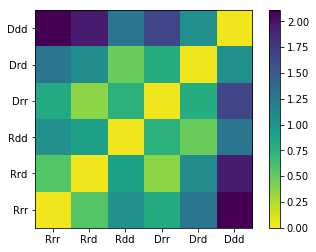

In [10]:
order = 'Rrr Rrd Rdd Drr Drd Ddd'.split()
_, im = plot_matrix(angle_data, order, vmin=0, origin='lower', cmap='viridis_r')
plt.colorbar(im)

These plots will be compared to the model results.

## Model details and implementation

The model is fully explained in the paper (cite nestor's judges paper), but for completness we restate some of the relevant information to implement a simulation class for it.

Each panel is composed of 3 judges, each judge being an apointee of some U.S. president, so each judge is supposed to be affiliated to either the Democratic Party or the Republican Party. 
In the model we refer to two distinct political parties, `A` and `B`, and each agent representing a judge belongs to either party `A` or `B`.
We assume the relevant elements of the judges decisions to be the Law, the party ideology and a personality component.

In [269]:
from agents_base import *
from numpy import (vstack, split, arange, ones, zeros, 
                   r_, eye, array, stack, fill_diagonal,
                   linspace, cos, sin)
from numpy.linalg import norm
from numpy.random import randn, choice


class JudgePanels(HEODAgentSociety):
    N, P = 18, 15  # number of agents, internal dimension and number of issues
    panel_compositions = ('Aaa', 'Aab', 'Abb', 'Bbb', 'Bba', 'Baa')  # types of panel by political affiliation
    panel_indices = vstack(split(arange(N), len(panel_compositions)))  # agent indices for each panel
    panel_map = {c: i for (c, i) in zip(panel_compositions, panel_indices)}
    focal_agents = list(range(0,18,3))  # the agent indices corresponding to the capital letters

    def __init__(self, K, components_A, components_B, mu0XX, mu0XY, c0A, c0B, s20, 
                 *args, opinion_norm_scale=1., issues_angular_bounds=(-pi/2,pi/2), **params):
        """Society of agents representing panels of judges apointed by presidents 
        of political affiliation A or B.
          The society has 18 agents interacting in groups of 3, representing the 6 
        possible composition panels: Aaa, Aab, Abb, Bbb, Bba, Baa.
          The notation Xyz is to be understood as the focal agent has political
        affiliation X in a panel with agents with political affiliations y and z.
          The initial opinion state for the judges is composed by a law component,
        representing the knowledge of the law and common to all agents, a party
        component, represent the political attitude and opposite for A and B, and
        a personality component of random charater.
          To initialize the society, the weights `alpha_law`, `alpha_party` and 
        `alpha_person` are used to build the opinion vectors.
          The opinion uncertainty is a party dependent multiple of the identity 
        matrix, with the multiples being the parameters `c0A` and `c0B`.
          For the distrust, we use two paramenters `mu0XX` and `mu0XY` to characterize
        the distrust attributed between members of party X to members of X and Y,
        respectively.
          Last, the distrust uncertainty is equal to everyone, being a multiple of the
        matrix will all entries equal to 1 and given by the parameter `s20`.
        
        Inputs:
        =======
          - alpha_law, alpha_party, alpha_person: floats - weights to initial opinion
          vector components of law, party and personality.
          - mu0XX, mu0XY: floats - intra and extra-party initial distrust
          - c0A, c0B: positive floats - initial opinion uncertainties for each party
          - s20: positive float - initial distrust uncertainty
          - opinion_norm_scale: (keyword only) float, defaults to 1.0 - the value of
                                norm for the agents' opinion vectors

        API:
        ====
          Although you can use any method inside this object, it intended to be used
          a iterator with the `dynamics` function, so we only give a description for
          the methods provided to this end:
          - update(*args, **param): Method to make a random move using the Entropic
          Dynamics of Learning. The Options section covers the parameters recognized
          - reset(): Method to reset the system to its initial state.
          - observables: Propery to compute and return all the observables in this
          system.
          
          There are, also, three more properties to retrieve data about the parameters
          and history of interaction:
          - describe: dict with the parameters used to initialize the system
          - describe_latex: raw string with LaTeX formated names and values of initial
                            parameters
          - log_book: list of dicts with the history of interactions.

          Options:
          --------
            Initialization Options:
            -----------------------
              opinion_norm_scale: positive float; default is 1.0 - gives the bound for the
                scale for the norm of opinion vectors.
                
              issues_angular_bounds: pair of floats; default is (-pi/2,pi/2) - the bounding
                angles to generate the issue list from the law and party
                components.
                 
            Options for the `update` method:
            --------------------------------
              constants: tuple with acceptable values 'norm', 'C', 's2', 'bounds'; default 
                is () - each value keeps the respective variable fixed under the dynamics,
                where 'norm' is for the opinion vectors, 'C' is for the opinion uncertainty,
                's2' is for the distrust uncertainty and 'bounds' is for the distrust interval.
                
              issues_probability: (keyword only) 1d-array with 15 entries summing to 1; default 
              is `None` - the probability mass for each issue in the list.
        """
        assert (c0A >= 0) and (c0B >= 0) and (s20 >= 0)
        assert len(issues_angular_bounds) == 2
        assert len(components_A) == len(components_B) == 3
#         self.alpha_law = alpha_law
#         self.alpha_party = alpha_party
#         self.alpha_person = alpha_person
        self.components_A, self.components_B = components_A, components_B
        self.mu0XX, self.mu0XY = mu0XX, mu0XY
        self.c0A, self.c0B = c0A, c0B
        self.s20 = s20
        self.K = K
        self.opinion_norm_scale = opinion_norm_scale
        self.issues_angular_bounds = issues_angular_bounds

        # Building the initial opinion vectors
        self.law_vector = ones(K)/norm(ones(K))  # vector repesenting the kwoledge of the law
        self.party_vector = r_[(K//2)*[-1.]+(K%2)*[0.]+(K//2)*[1.]]  # vector representing the political attitude
        personality_vector = randn(self.N, self.K)
        personality_vector /= row_norm(personality_vector)
        alpha_law_A, alpha_party_A, alpha_person_A = components_A
        alpha_law_B, alpha_party_B, alpha_person_B = components_B
        
        #             law component                 party compoenent
        A = alpha_law_A*self.law_vector + alpha_party_A*self.party_vector
        B = alpha_law_B*self.law_vector - alpha_party_B*self.party_vector
        # personality weights
        alpha_person = array(self.tile_values_for_panels(alpha_person_A, alpha_person_B))[:,None]
#         alpha_person = array([alpha_person_A,alpha_person_A,alpha_person_A,
#                               alpha_person_A,alpha_person_A,alpha_person_B,
#                               alpha_person_A,alpha_person_B,alpha_person_B,
#                               alpha_person_B,alpha_person_B,alpha_person_B,
#                               alpha_person_B,alpha_person_B,alpha_person_A,
#                               alpha_person_B,alpha_person_A,alpha_person_A])[:,None]
        
#         #            A a a A a b A b b B b b B b a B a a                  personality component
#         w0 = vstack([A,A,A,A,A,B,A,B,B,B,B,B,B,B,A,B,A,A]) + alpha_person*personality_vector
        #                                                             personality component
        w0 = vstack(self.tile_values_for_panels(A, B)) + alpha_person*personality_vector
        w0 *= opinion_norm_scale/row_norm(w0)
        
        # Building the initial opinion uncertainties
        I = eye(self.K)
        CA, CB = c0A*I, c0B*I
#         #            A  a  a  A  a  b  A  b  b  B  b  b  B  b  a  B  a  a
#         C0 = stack([CA,CA,CA,CA,CA,CB,CA,CB,CB,CB,CB,CB,CB,CB,CA,CB,CA,CA], axis=0)
        C0 = stack(self.tile_values_for_panels(CA, CB), axis=0)
        
        # Building the initial distrust proxies - X in (A,B), Y in (A,B), i, j, k are agents
        #                      i     j     k
        muXxx_tile = array([[-10, mu0XX, mu0XX],   # ii==XX, ij==XX, ik==XX
                            [mu0XX, -10, mu0XX],   # ji==XX, jj==XX, jk==XX
                            [mu0XX, mu0XX, -10]])  # ki==XX, kj==XX, kk==XX
        muXxy_tile = array([[-10, mu0XX, mu0XY],   # ii==XX, ij==XX, ik==XY
                            [mu0XX, -10, mu0XY],   # ji==XX, jj==XX, jk==XY
                            [mu0XY, mu0XY, -10]])  # ki==XY, kj==XY, kk==XX
        muXyy_tile = array([[-10, mu0XY, mu0XY],   # ii==XX, ij==XY, ik==XY
                            [mu0XY, -10, mu0XX],   # ji==XY, jj==XX, jk==XX
                            [mu0XY, mu0XX, -10]])  # ki==XY, kj==XX, kk==XX
        mu_map = {c: mt for (c, mt) in zip(self.panel_compositions,[muXxx_tile, muXxy_tile, muXyy_tile]*2)}
        mu0 = zeros((self.N, self.N))
        panel_pairs = stack([vstack([[i,j] for i in p for j in p]) for p in self.panel_indices], axis=0)
        for panel, indices in self.panel_map.items():
            pair_indices = vstack([[i,j] for i in indices for j in indices])
            I, J = split(pair_indices, 2, axis=1)
            mu0[I, J] = mu_map[panel].reshape(I.shape)
            
        # Building the initial distrust uncertainty
        s20 = s20*ones((self.N, self.N))
        fill_diagonal(s20, 0.0)
        
        # building the issue_list
        thetas = linspace(*issues_angular_bounds, self.P)
        self.issue_list = vstack([cos(t)*self.law_vector + sin(t)*self.party_vector
                                  for t in thetas])
        
        # some info about the state and interactions
        self.interaction_counter = 0
        self.log_book = []

        # let the super class prepare the remaining of the object
        super().__init__(w0, C0, mu0, s20)
    
    @staticmethod
    def tile_values_for_panels(vA, vB):
        #       A  a  a | A  a  b | A  b  b | B  b  b | B  b  a | B  a  a
        return [vA,vA,vA, vA,vA,vB, vA,vB,vB, vB,vB,vB, vB,vB,vA, vB,vA,vA]
    
    def pick_issue(self, *args, issues_probability=None, **params):
        k = choice(len(self.issue_list), p=issues_probability,
                   size=len(self.panel_compositions), replace=True)
        x = self.issue_list[k]
        return x, k

    def pick_agents(self, *args, **params):
        pairs = vstack([choice(p, size=2, replace=False)
                        for p in self.panel_indices])
        return pairs

    def update(self, *args, constants=(), **params):
        """Method to update the state of the system by running the sequence:
            1. pick_issue
            2. pick_agents
            3. interaction
           Each step receives the params dict to enable fine control, but a few
           of the keyword parameters are emphasized, as described below:
        
           Keyword only Inputs:
           --------------------
             constants: tuple with acceptable values 'norm', 'C', 's2', 'bounds'; default 
               is () - each value keeps the respective variable fixed under the dynamics,
               where 'norm' is for the opinion vectors, 'C' is for the opinion uncertainty,
               's2' is for the distrust uncertainty and 'bounds' is for the distrust interval.

             issues_probability: (keyword only) 1d-array with 15 entries summing to 1; default 
               is `None` - the probability mass for each issue in the list.
        """
        xs, ks = self.pick_issue(*args, **params)
        pairs = self.pick_agents(*args, **params)
        for ((i,j),x, k) in zip(pairs, xs, ks):
            self.interaction(i, j, x*self.opinion_norm_scale,
                             *args, constants=constants, **params)
            self.write_to_log_book(((i,j),k))
            
    @property
    def opinions(self):
        u = self.w[self.focal_agents, :]
        h = (u/row_norm(u))@self.issue_list.T
        return (self.panel_compositions, h)
        
    @property
    def observables(self):
        if not hasattr(self, '_observables'):
            self._observables = 'opinions'.split()
        return {n:getattr(self, n) for n in self._observables}
    
    @property
    def describe(self):
        if not hasattr(self, '_info'):
            self._info = dict(
#                 alpha_law={'value':self.alpha_law, 
#                            'descr':r'$\alpha_L={}$'.format(self.alpha_law)},
#                 alpha_party={'value':self.alpha_party,
#                              'descr':r'$\alpha_P={}$'.format(self.alpha_party)},
#                 alpha_person={'value':self.alpha_person,
#                               'descr':r'$\alpha_\eta={}$'.format(self.alpha_person)},
                components_A={'value':self.components_A,
                              'descr':r'$\alpha_A={}$'.format(self.components_A)},
                components_B={'value':self.components_B,
                              'descr':r'$\alpha_A={}$'.format(self.components_B)},
                mu0XX={'value':self.mu0XX,
                       'descr':r'$\mu_{0,XX}=$' + '${}$'.format(self.mu0XX)}, 
                mu0XY={'value':self.mu0XY,
                       'descr':r'$\mu_{0,XY}=$' + '${}$'.format(self.mu0XY)},
                c0A={'value':self.c0A,
                       'descr':r'$c_{0,A}=$' + '${}$'.format(self.c0A)},
                c0B={'value':self.c0B,
                       'descr':r'$c_{0,B}=$' + '${}$'.format(self.c0B)},
                s20={'value':self.s20,
                       'descr':r'$s_0^2=$' + '${}$'.format(self.s20)}
            )            
        return self._info
    
    @property
    def describe_latex(self):
        info = self.describe
        info_str = ', '.join([v['descr'] for v in info.values()])
        return info_str
    
    def write_to_log_book(self, ij_x):
        (i,j),x = ij_x
        n = self.interaction_counter
        entry = {'interaction': n, 'agents': (i, j), 'issue': x}
        self.log_book.append(entry)

Just to test out the model, lets do a simple dummy simulation and look for the respctive plots we did above

In [286]:
K = 5
#aL, aP, aE = 5., 1., 1.
alpha_A, alpha_B = [5.,1.,1.], [5., 1., 1.]
mu0XX, mu0XY = -1., -1.
c0A, c0B = .1, .1
s20 = .001
judges_model = JudgePanels(K, alpha_A, alpha_B, mu0XX, mu0XY, c0A, c0B, s20, issues_angular_bounds=(-pi/2,pi/2))

In [287]:
cols, vals = judges_model.opinions
initial_opinions = pd.DataFrame(vals.T, columns=cols).transform(lambda x: x/norm(x))
initial_overlaps = initial_opinions.T.dot(initial_opinions)
initial_angles = initial_overlaps.transform(lambda x: arccos(0.999*x))

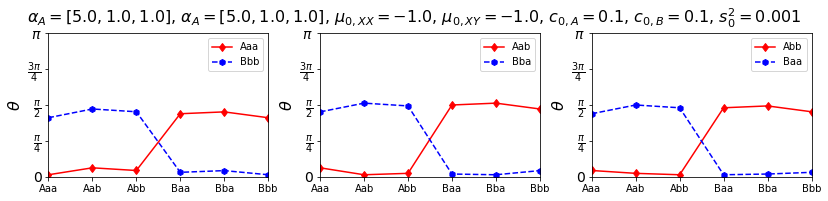

In [288]:
x_order_agents = 'Aaa Aab Abb Baa Bba Bbb'.split()
_ = plot_angle_pairs(initial_angles, x_order_agents,
                     ['Aaa', 'Bbb'], ['Aab', 'Bba'], ['Abb', 'Baa'],
                     title=judges_model.describe_latex,
                     style=['-d', '--h'], color=['r', 'b'])

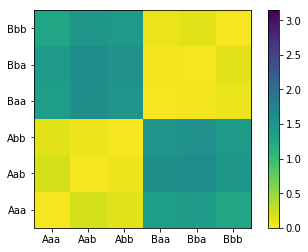

In [289]:
_, im = plot_matrix(initial_angles, x_order_agents, vmin=0, vmax=pi, origin='lower', cmap='viridis_r')
plt.colorbar(im)

In [290]:
_ = record_trajectory(judges_model, 300, record_step=lambda n: n==False, in_place=True)
cols, vals = judges_model.opinions
agents_opinions = pd.DataFrame(vals.T, columns=cols).transform(lambda x: x/norm(x))
agents_overlaps = agents_opinions.T.dot(agents_opinions)
agents_angles = agents_overlaps.transform(lambda x: arccos(0.999*x))

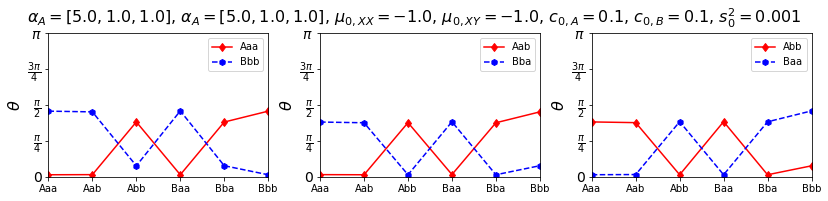

In [291]:
x_order_agents = 'Aaa Aab Abb Baa Bba Bbb'.split()
_ = plot_angle_pairs(agents_angles, x_order_agents,
                     ['Aaa', 'Bbb'], ['Aab', 'Bba'], ['Abb', 'Baa'],
                     title=judges_model.describe_latex,
                     style=['-d', '--h'], color=['r', 'b'])

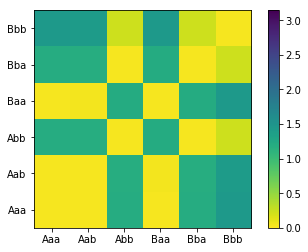

In [292]:
_, im = plot_matrix(agents_angles, x_order_agents, vmin=0, vmax=pi,origin='lower', cmap='viridis_r')
plt.colorbar(im)

In [293]:
judges_model.log_book[:5]

[{'agents': (0, 1), 'interaction': 1, 'issue': 0},
 {'agents': (4, 3), 'interaction': 2, 'issue': 0},
 {'agents': (6, 7), 'interaction': 3, 'issue': 11},
 {'agents': (9, 10), 'interaction': 4, 'issue': 10},
 {'agents': (13, 12), 'interaction': 5, 'issue': 4}]

The model simualator class is built to be easy to specify the initial conditions matching each of the following intuitive scenarios:
  1. Courteuos and Certain: $\mu_{0,XX} = \mu_{0,XY} < 0$ and $s_0^2 \approx 0$
  2. Courteous and Uncertain: $\mu_{0,XX} = \mu_{0,XY} < 0$ and $s_0^2 > 0$
  3. Discourteous and Certain: $\mu_{0,XX} < \mu_{0,XY} $ and $s_0^2 \approx 0$
  4. Discourteous and Uncertain: $\mu_{0,XX} = \mu_{0,XY} < 0$ and $s_0^2 \approx 0$
  
We can also impose the distinction between liberals and conservatives through the specification of liberal index $\rho_{0,X} = \frac{1}{\sqrt{1+c_{0,X}}}$, where $c_{0,X}$ stands for the opinion uncertainty for members of party $X$.
The liberal index is closer to $1$ when the agent is more liberal and closer to $0$ when its more conservative.
As in the paper [For whom will the Bayesian agents vote?](http://journal.frontiersin.org/article/10.3389/fphy.2015.00025/full), the empirical data from MFT suggests values of $\rho$ between $0.76$ and $0.91$ for american citzens, which correspond to values of $c$ $c_{0,A} = 0.74$ amd $c_{0,B} = 0.21$.
Notice the relative value conservatives and liberals is of order $3$, so we could choose different values of $c$ keeping this relation if we would like to retain the opinion learning time scale.

The last thing to control is the relative importance of the initial components of the law, the party and personality.

Lets proceed by simulating each o the four cases:

### Courteous Certain

In [294]:
# distrust settings
mu0XX, mu0XY = -1., -1. # courteous 
s20 = .1  # certain

# opinion settings
K = 5  # internal dimension
#aL, aP, aE = 4., 1., 2.  # law, party and personality weights
# initial opinion vector components: [alpha_law, alpha_party, alpha_person]
alpha_A, alpha_B = [5., 2., 2.], [5., 2., 4.]
# the following is to account for the difference between liberals and conservatives
rho_C, rho_L = 0.76, 0.91  # most conservative and most liberal indices
ratio_cC_cL = (1/(rho_C**2) - 1)/(1/(rho_L**2) - 1)  # ~ 3.5
c_base = 0.75
c0A, c0B = c_base*ratio_cC_cL, c_base # A is conservative, B is liberal
# c0A, c0B = c_base, c_base*ratio_cC_cL  # A is liberal, B is conservative

# the angular bouds used to generate the issue list from the law and party vectors
angular_bounds = (-pi/2, pi/2)  #  unbiased
# angular_bounds = (0, pi/2)  #  A party biased
# angular_bounds = (-pi/2, 0)  #  B party biased

# simulation
judges_sims = [JudgePanels(K, alpha_A, alpha_B, mu0XX, mu0XY, c0A, c0B, s20, 
                           opinion_norm_scale=sqrt(K), 
                           issues_angular_bounds=angular_bounds)
               for _ in range(50)]
for sim in judges_sims:
    _ = record_trajectory(sim, 100, constants=(), record_step=lambda n: n==False, in_place=True)

In [295]:
# take mean after the overlaps
# agents_opinions = [pd.DataFrame(sim.opinions[1].T, columns=sim.opinions[0]).transform(lambda x: x/norm(x))
#                    for sim in judges_sims]
# agents_overlaps = [ot.T.dot(ot) for ot in agents_opinions]
# agents_angles = [ot.transform(lambda x: arccos(0.999*x)) for ot in agents_overlaps]
# mean_angles = sum(agents_angles)/len(agents_angles)

# take the mean before computing the overlaps
agents_opinions = [pd.DataFrame(sim.opinions[1].T, columns=sim.opinions[0])
                   for sim in judges_sims]
mean_opinions = (sum(agents_opinions)/len(agents_opinions)).transform(lambda x: x/norm(x))
mean_overlaps = mean_opinions.T.dot(mean_opinions)
mean_angles = mean_overlaps.transform(lambda x: arccos(0.999*x))

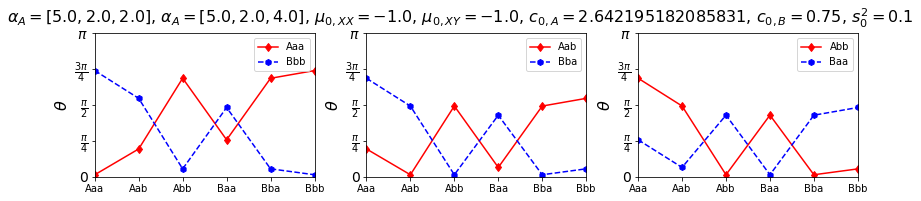

In [296]:
x_order_agents = 'Aaa Aab Abb Baa Bba Bbb'.split()
_ = plot_angle_pairs(mean_angles, x_order_agents,
                     ['Aaa', 'Bbb'], ['Aab', 'Bba'], ['Abb', 'Baa'],
                     title=judges_sims[0].describe_latex,
                     style=['-d', '--h'], color=['r', 'b'])

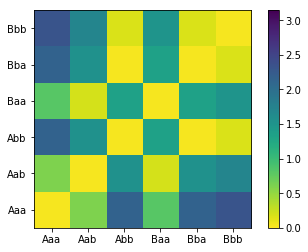

In [297]:
agents_order = 'Aaa Aab Abb Baa Bba Bbb'.split()
_, im = plot_matrix(mean_angles, agents_order, vmin=0, vmax=pi, origin='lower', cmap='viridis_r')
plt.colorbar(im)